In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

Setting of the main hyper-parameters of the model
=================================================


In [4]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/"  # Data saving folder
if os.path.exists(SAVE_PATH) == False:
    os.makedirs(SAVE_PATH)

PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Loading of the MNIST dataset
============================

We import the MNIST dataset from *Keras*. To speedup the evaluation of
this demo we use only a small number of training and test images.
Obviously, better results are achievable when using the full dataset.


In [5]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

Quantum circuit as a convolution kernel
=======================================

We follow the scheme described in the introduction and represented in
the figure at the top of this demo.

We initialize a PennyLane `default.qubit` device, simulating a system of
$4$ qubits. The associated `qnode` represents the quantum circuit
consisting of:

1.  an embedding layer of local $R_y$ rotations (with angles scaled by a
    factor of $\pi$);
2.  a random circuit of `n_layers`;
3.  a final measurement in the computational basis, estimating $4$
    expectation values.


In [6]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The next function defines the convolution scheme:

1.  the image is divided into squares of $2 \times 2$ pixels;
2.  each square is processed by the quantum circuit;
3.  the $4$ expectation values are mapped into $4$ different channels of
    a single output pixel.

::: {.note}
::: {.title}
Note
:::

This process halves the resolution of the input image. In the standard
language of CNN, this would correspond to a convolution with a
$2 \times 2$ *kernel* and a *stride* equal to $2$.
:::


In [7]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Quantum pre-processing of the dataset
=====================================

Since we are not going to train the quantum convolution layer, it is
more efficient to apply it as a \"pre-processing\" layer to all the
images of our dataset. Later an entirely classical model will be
directly trained and tested on the pre-processed dataset, avoiding
unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder `SAVE_PATH`. Once
saved, they can be directly loaded by setting `PREPROCESS = False`,
otherwise the quantum convolution is evaluated at each run of the code.


In [8]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


Let us visualize the effect of the quantum convolution layer on a batch
of samples:


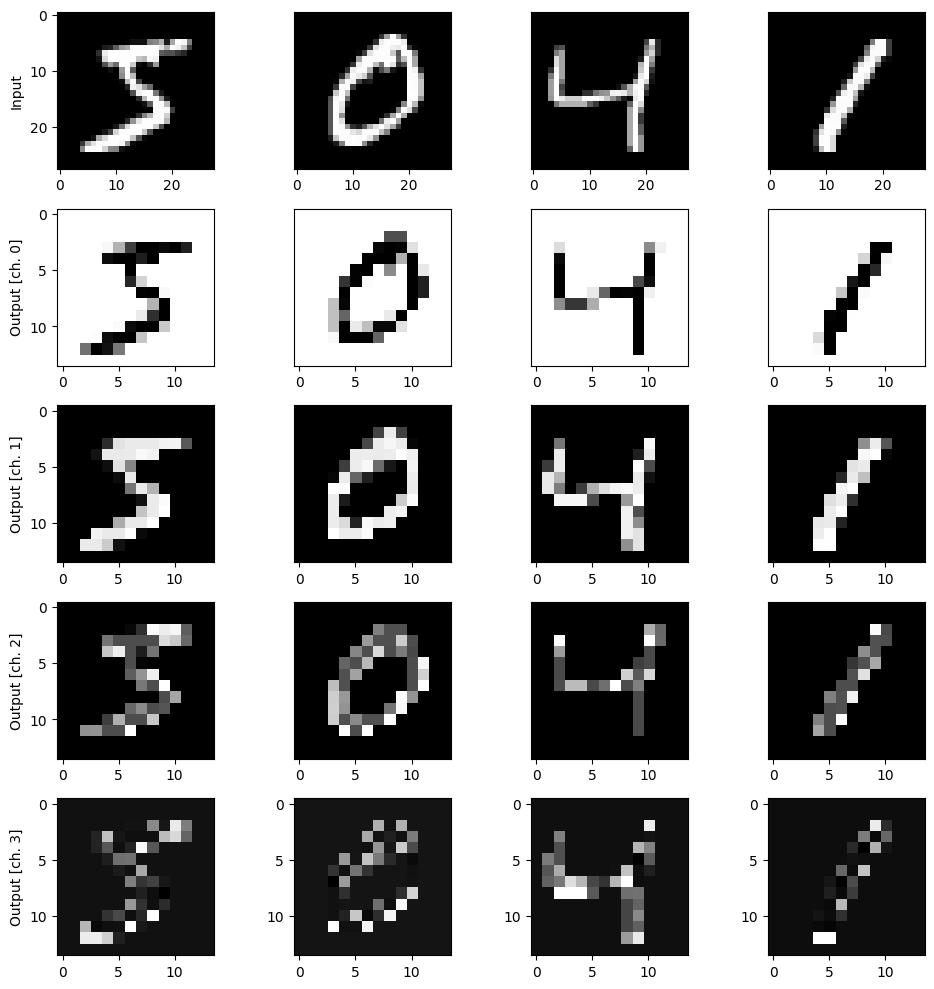

In [9]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, the $4$ output channels generated by the quantum
convolution are visualized in gray scale.

One can clearly notice the downsampling of the resolution and some local
distortion introduced by the quantum kernel. On the other hand the
global shape of the image is preserved, as expected for a convolution
layer.


Hybrid quantum-classical model
==============================

After the application of the quantum convolution layer we feed the
resulting features into a classical neural network that will be trained
to classify the $10$ different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output
nodes with a final *softmax* activation function.

The model is compiled with a *stochastic-gradient-descent* optimizer,
and a *cross-entropy* loss function.


In [10]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Training
========

We first initialize an instance of the model, then we train and validate
it with the dataset that has been already pre-processed by a quantum
convolution.


In [11]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - 19ms/step - accuracy: 0.1400 - loss: 2.8998 - val_accuracy: 0.2667 - val_loss: 2.0665
Epoch 2/30
13/13 - 0s - 2ms/step - accuracy: 0.2400 - loss: 2.1117 - val_accuracy: 0.2667 - val_loss: 1.9577
Epoch 3/30
13/13 - 0s - 2ms/step - accuracy: 0.4200 - loss: 1.7738 - val_accuracy: 0.3667 - val_loss: 1.8288
Epoch 4/30
13/13 - 0s - 3ms/step - accuracy: 0.6200 - loss: 1.4476 - val_accuracy: 0.4333 - val_loss: 1.6635
Epoch 5/30
13/13 - 0s - 2ms/step - accuracy: 0.7600 - loss: 1.2039 - val_accuracy: 0.5000 - val_loss: 1.5530
Epoch 6/30
13/13 - 0s - 2ms/step - accuracy: 0.8400 - loss: 1.0011 - val_accuracy: 0.5333 - val_loss: 1.4741
Epoch 7/30
13/13 - 0s - 2ms/step - accuracy: 0.8800 - loss: 0.8413 - val_accuracy: 0.5667 - val_loss: 1.4054
Epoch 8/30
13/13 - 0s - 2ms/step - accuracy: 0.9000 - loss: 0.7139 - val_accuracy: 0.6000 - val_loss: 1.3481
Epoch 9/30
13/13 - 0s - 2ms/step - accuracy: 0.9600 - loss: 0.6097 - val_accuracy: 0.6333 - val_loss: 1.3024
Epoch 10/30
13/13 

In order to compare the results achievable with and without the quantum
convolution layer, we initialize also a \"classical\" instance of the
model that will be directly trained and validated with the raw MNIST
images (i.e., without quantum pre-processing).


In [12]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - 19ms/step - accuracy: 0.1600 - loss: 2.3277 - val_accuracy: 0.1333 - val_loss: 2.2397
Epoch 2/30
13/13 - 0s - 2ms/step - accuracy: 0.4200 - loss: 1.9016 - val_accuracy: 0.2333 - val_loss: 2.0656
Epoch 3/30
13/13 - 0s - 2ms/step - accuracy: 0.6400 - loss: 1.6156 - val_accuracy: 0.4000 - val_loss: 1.9157
Epoch 4/30
13/13 - 0s - 2ms/step - accuracy: 0.8400 - loss: 1.3864 - val_accuracy: 0.4333 - val_loss: 1.7857
Epoch 5/30
13/13 - 0s - 2ms/step - accuracy: 0.8800 - loss: 1.1975 - val_accuracy: 0.4667 - val_loss: 1.6766
Epoch 6/30
13/13 - 0s - 2ms/step - accuracy: 0.9000 - loss: 1.0407 - val_accuracy: 0.5000 - val_loss: 1.5866
Epoch 7/30
13/13 - 0s - 2ms/step - accuracy: 0.9000 - loss: 0.9100 - val_accuracy: 0.5667 - val_loss: 1.5122
Epoch 8/30
13/13 - 0s - 2ms/step - accuracy: 0.9200 - loss: 0.8005 - val_accuracy: 0.6000 - val_loss: 1.4499
Epoch 9/30
13/13 - 0s - 2ms/step - accuracy: 0.9400 - loss: 0.7082 - val_accuracy: 0.5667 - val_loss: 1.3973
Epoch 10/30
13/13 

Results
=======

We can finally plot the test accuracy and the test loss with respect to
the number of training epochs.


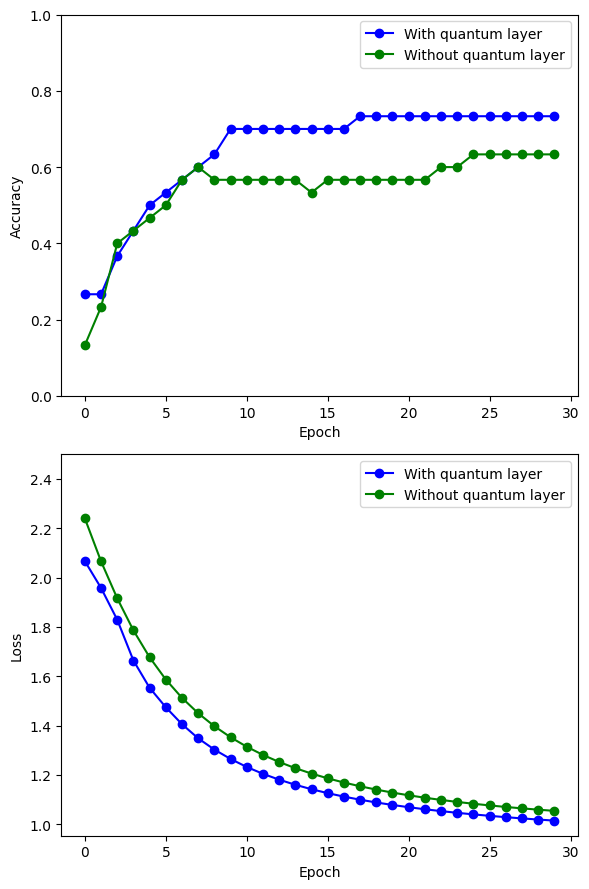

In [14]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

References
==========

1.  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.

About the author
================
